# 目录

#### 1、数据整理与可视化

（1）宽数据转长数据

（2）增加虚拟变量

（3）对数据可视化

#### 2、模型介绍

#### 3、R语言实现
#### 

# 多层线性模型处理对子追踪数据

# Dyadic Multilevel Model for Examining Intradyad Covariation

前面我们讲过，探讨对子之间的相互影响的模型——主客体互倚模型（Actor Partner Interdependence Model，APIM）。

#### 我们以这样一个例子来探讨此问题：

有100对夫妻，每个人提供day-to-day的报告，包括：(a)工作中压力源数量; (b)工作不满意度

##### 欲回答以下问题：

每日工作压力源的数量是否与当天关系满意度有关？主体效应？客体效应？ 角色差异？


In [16]:
library(ggplot2)
library(nlme)
library(psych)
library(dplyr)
library(reshape2)

In [19]:
# 载入数据
BLdyads_long <- read.csv(file="C:/Users/77387/Desktop/Data_analysis_courses/data/BLdyads_long.csv",header=TRUE)
head(BLdyads_long)

,coupleid,time,time7c,f_personid,f_reldis,f_wrkstrs,f_wrkstrsc,f_wrkstrsc_b,f_wrkstrsc_w,m_personid,m_reldis,m_wrkstrs,m_wrkstrsc,m_wrkstrsc_b,m_wrkstrsc_w
,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,1,0,-1.5000000,1,3.03,3,0.0095238,-0.3238095,0.3333333,2,4.46,3,0.0095238,-0.1333333,0.1428571
2,1,1,-1.3571429,1,4.62,3,0.0095238,-0.3238095,0.3333333,2,4.88,3,0.0095238,-0.1333333,0.1428571
3,1,2,-1.2142857,1,2.85,3,0.0095238,-0.3238095,0.3333333,2,4.58,3,0.0095238,-0.1333333,0.1428571
4,1,3,-1.0714286,1,6.40,4,1.0095238,-0.3238095,1.3333333,2,4.49,1,-1.9904762,-0.1333333,-1.8571429
5,1,4,-0.9285714,1,2.54,1,-1.9904762,-0.3238095,-1.6666667,2,5.04,3,0.0095238,-0.1333333,0.1428571
6,1,5,-0.7857143,1,5.16,2,-0.9904762,-0.3238095,-0.6666667,2,4.87,3,0.0095238,-0.1333333,0.1428571


Couple ID：夫妻编号

Person ID (e.g., 1 = partner 1, 2 = partner 2) 

Time (时间，第几天)

time7c(对时间做中心化处理)

Gender (性别)

 reldis(因变量, 关系不满意)

 wrkstrs(自变量，工作压力)

wrkstrsc：工作压力中心化处理后（一个对子一个得分）

wrkstrsb：工作压力取均值转化为特质性变量（一个人一个得分）

wrkstrsw：工作压力状态性（每个人每个时间点一个得分）

#### 把男性和女性的关系不满意度合并为一个变量（宽数据转长数据） 

In [20]:

BLdyads_melt <- melt(data = BLdyads_long,
                     id.vars = c("coupleid","time","time7c",
                                 "f_personid",#"f_reldis",
                                 "f_wrkstrs","f_wrkstrsc","f_wrkstrsc_b","f_wrkstrsc_w",
                                 "m_personid",#"m_reldis",
                                 "m_wrkstrs","m_wrkstrsc","m_wrkstrsc_b","m_wrkstrsc_w"),
                     na.rm = FALSE, 
                     value.name = "reldis") #naming new variable

head(BLdyads_melt)

,coupleid,time,time7c,f_personid,f_wrkstrs,f_wrkstrsc,f_wrkstrsc_b,f_wrkstrsc_w,m_personid,m_wrkstrs,m_wrkstrsc,m_wrkstrsc_b,m_wrkstrsc_w,variable,reldis
,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,1,0,-1.5000000,1,3,0.0095238,-0.3238095,0.3333333,2,3,0.0095238,-0.1333333,0.1428571,f_reldis,3.03
2,1,1,-1.3571429,1,3,0.0095238,-0.3238095,0.3333333,2,3,0.0095238,-0.1333333,0.1428571,f_reldis,4.62
3,1,2,-1.2142857,1,3,0.0095238,-0.3238095,0.3333333,2,3,0.0095238,-0.1333333,0.1428571,f_reldis,2.85
4,1,3,-1.0714286,1,4,1.0095238,-0.3238095,1.3333333,2,1,-1.9904762,-0.1333333,-1.8571429,f_reldis,6.40
5,1,4,-0.9285714,1,1,-1.9904762,-0.3238095,-1.6666667,2,3,0.0095238,-0.1333333,0.1428571,f_reldis,2.54
6,1,5,-0.7857143,1,2,-0.9904762,-0.3238095,-0.6666667,2,3,0.0095238,-0.1333333,0.1428571,f_reldis,5.16


##### 增加虚拟变量

In [23]:

BLdyads_melt$female <- ifelse(BLdyads_melt$variable == "f_reldis", 1, 0)
BLdyads_melt$male <- ifelse(BLdyads_melt$variable == "m_reldis", 1, 0)


In [24]:
# 添加另一个性别变量
BLdyads_melt$gender <- as.numeric(factor(BLdyads_melt$variable))

# 家庭内，每个人的编号
BLdyads_melt$personid <- ifelse(BLdyads_melt$female == 1, BLdyads_melt$f_personid, BLdyads_melt$m_personid)
head(BLdyads_melt)

,coupleid,time,time7c,f_personid,f_wrkstrs,f_wrkstrsc,f_wrkstrsc_b,f_wrkstrsc_w,m_personid,m_wrkstrs,m_wrkstrsc,m_wrkstrsc_b,m_wrkstrsc_w,variable,reldis,female,male,gender,personid
,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1,0,-1.500000,1,3,0.0095238,-0.3238095,0.3333333,2,3,0.0095238,-0.1333333,0.1428571,f_reldis,3.03,1,0,1,1
2101,1,0,-1.500000,1,3,0.0095238,-0.3238095,0.3333333,2,3,0.0095238,-0.1333333,0.1428571,m_reldis,4.46,0,1,2,2
2,1,1,-1.357143,1,3,0.0095238,-0.3238095,0.3333333,2,3,0.0095238,-0.1333333,0.1428571,f_reldis,4.62,1,0,1,1
2102,1,1,-1.357143,1,3,0.0095238,-0.3238095,0.3333333,2,3,0.0095238,-0.1333333,0.1428571,m_reldis,4.88,0,1,2,2
3,1,2,-1.214286,1,3,0.0095238,-0.3238095,0.3333333,2,3,0.0095238,-0.1333333,0.1428571,f_reldis,2.85,1,0,1,1
2103,1,2,-1.214286,1,3,0.0095238,-0.3238095,0.3333333,2,3,0.0095238,-0.1333333,0.1428571,m_reldis,4.58,0,1,2,2


In [25]:
# 我们取我们需要用到的变量
BLdyads_doubleentry <- BLdyads_melt[ ,c("coupleid", "personid","time", "time7c",
                                "gender", "reldis","female", "male",
                                "f_wrkstrs", "f_wrkstrsc", "f_wrkstrsc_b", "f_wrkstrsc_w",
                                "m_wrkstrs", "m_wrkstrsc", "m_wrkstrsc_b", "m_wrkstrsc_w")]

head(BLdyads_doubleentry)

,coupleid,personid,time,time7c,gender,reldis,female,male,f_wrkstrs,f_wrkstrsc,f_wrkstrsc_b,f_wrkstrsc_w,m_wrkstrs,m_wrkstrsc,m_wrkstrsc_b,m_wrkstrsc_w
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,1,1,0,-1.500000,1,3.03,1,0,3,0.0095238,-0.3238095,0.3333333,3,0.0095238,-0.1333333,0.1428571
2101,1,2,0,-1.500000,2,4.46,0,1,3,0.0095238,-0.3238095,0.3333333,3,0.0095238,-0.1333333,0.1428571
2,1,1,1,-1.357143,1,4.62,1,0,3,0.0095238,-0.3238095,0.3333333,3,0.0095238,-0.1333333,0.1428571
2102,1,2,1,-1.357143,2,4.88,0,1,3,0.0095238,-0.3238095,0.3333333,3,0.0095238,-0.1333333,0.1428571
3,1,1,2,-1.214286,1,2.85,1,0,3,0.0095238,-0.3238095,0.3333333,3,0.0095238,-0.1333333,0.1428571
2103,1,2,2,-1.214286,2,4.58,0,1,3,0.0095238,-0.3238095,0.3333333,3,0.0095238,-0.1333333,0.1428571


## 对数据可视化

（1）描述自变量和因变量

（2）画一部分对子的变量关系，对子内是否有共变关系？

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


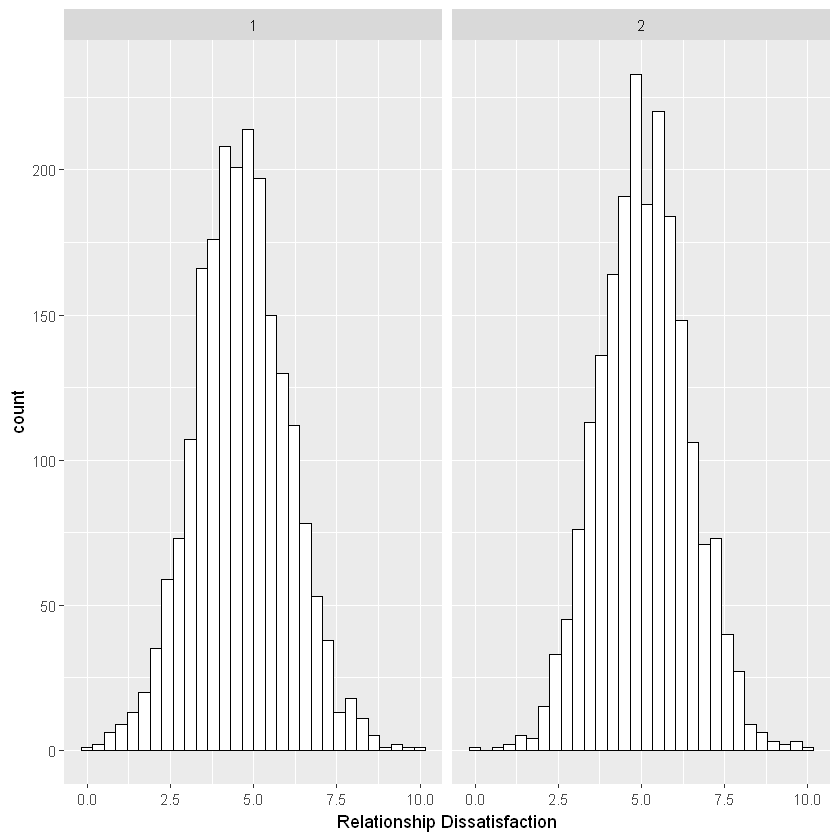

In [9]:
ggplot(data = BLdyads_doubleentry, aes(x = reldis)) +
  geom_histogram(fill = "white", color = "black") + 
  labs(x = "Relationship Dissatisfaction") +
  facet_grid(. ~ gender) # creating a separate plot for each gender

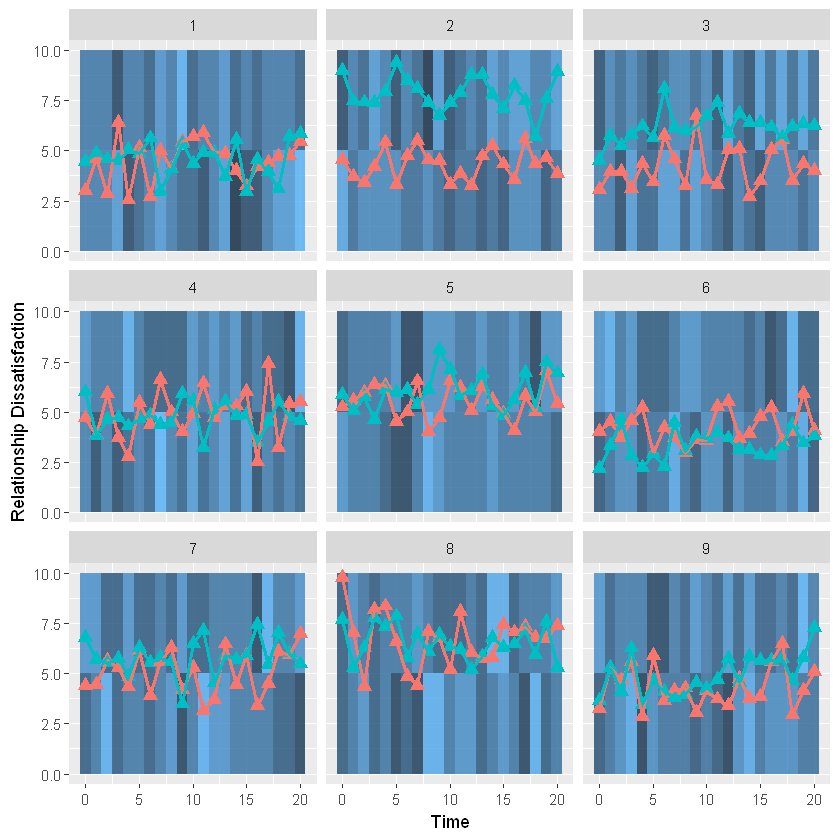

In [13]:
ggplot(data = subset(BLdyads_doubleentry, coupleid <= 9), aes(x = time, group = personid), legend = FALSE) +
  geom_rect(mapping = aes(xmin = time-.5, xmax = time+.5, ymin = 0, ymax = 5, fill = f_wrkstrsc_w), alpha = 0.6) + # creating rectangles in the background of the plot colored by female work stressors
  geom_rect(mapping = aes(xmin = time-.5, xmax = time+.5, ymin = 5, ymax = 10, fill = m_wrkstrsc_w), alpha = 0.6) + # creating rectangles in the background of the plot colored by male work stressors
  geom_point(aes(x = time, y = reldis, color = factor(gender)), shape = 17, size = 3) + # creating a different colored point for each gender
  geom_line(aes(x = time, y = reldis, color = factor(gender)), lty = 1, size=1) + # creating a different colored line for each gender
  xlab("Time") + 
  ylab("Relationship Dissatisfaction") + ylim(0, 10) +
  scale_x_continuous(breaks=seq(0, 20, by = 5)) + 
  facet_wrap( ~ coupleid) +# creating a separate plot for each dyad
  theme(legend.position = "none")

#### 个体间因素的情况

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


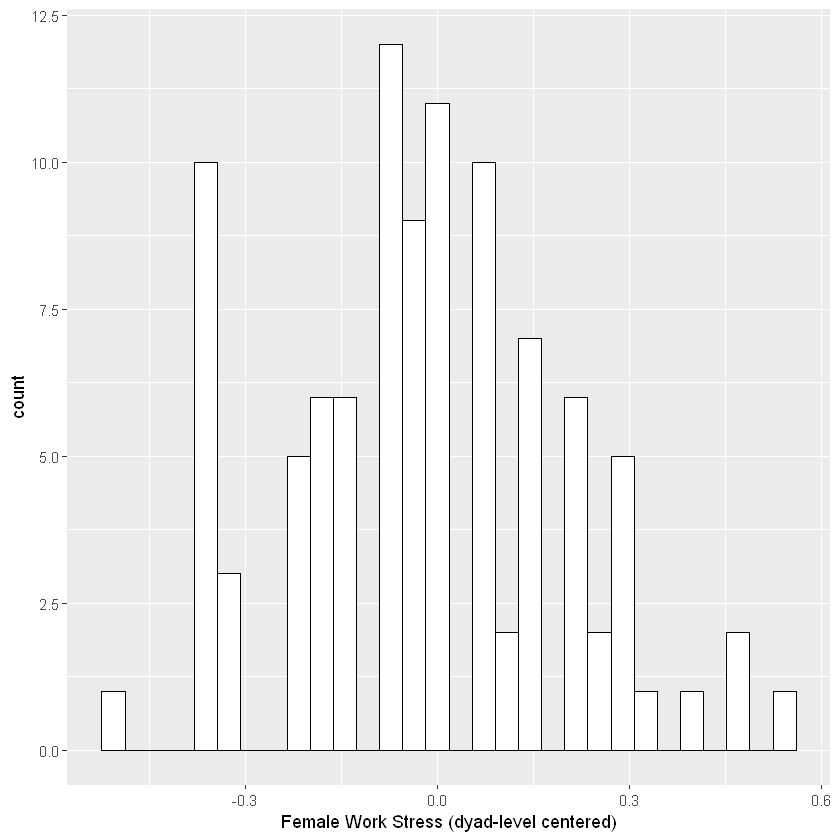

In [14]:
# 女性
ggplot(data = subset(BLdyads_doubleentry, time == 0 & female == 1), 
       aes(x = f_wrkstrsc_b)) +
  geom_histogram(fill = "white", color = "black") + 
  labs(x = "Female Work Stress (dyad-level centered)")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


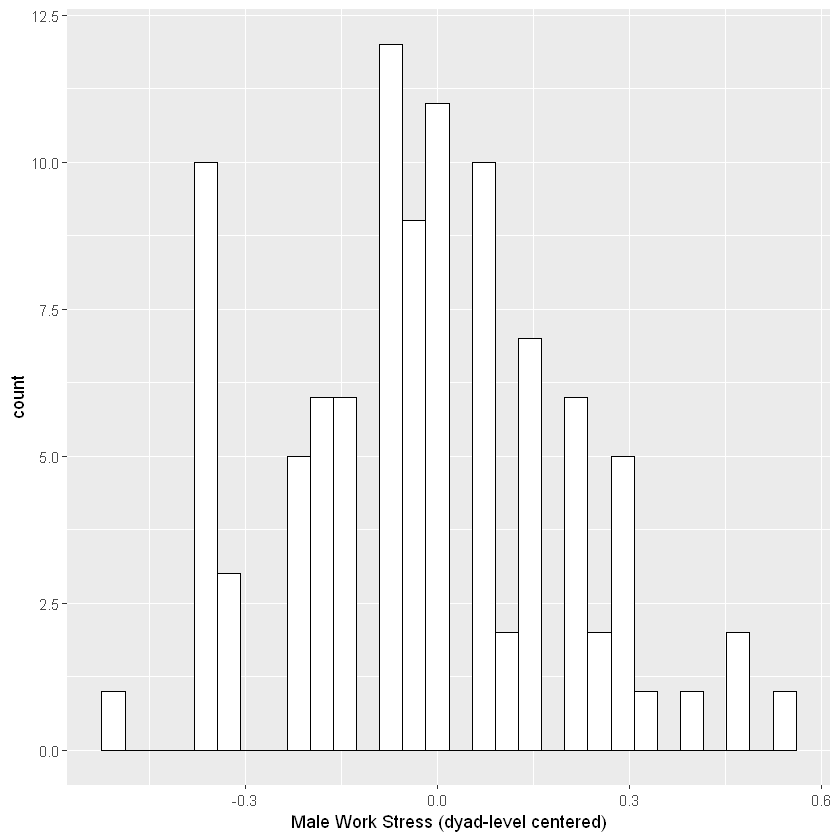

In [12]:
# 男性
ggplot(data = subset(BLdyads_doubleentry, time == 0 & male == 1), aes(x = f_wrkstrsc_b)) +
  geom_histogram(fill = "white", color = "black") + 
  labs(x = "Male Work Stress (dyad-level centered)")

# 多层线性模型

首先，我们生成一个模型，探讨关系不满意度（reldis）和工作压力源数量（wrkstrs）个体内和个体间的关联（工作压力源被中心化分离为两个变量 wrkstrscw 和 wrkdstrscb 两个变量）

第一层模型
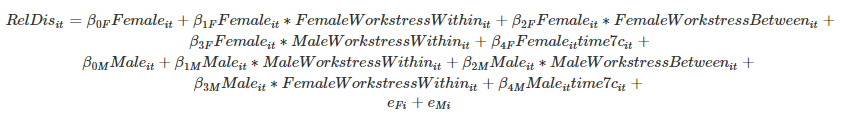

第二层模型
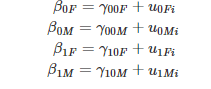


In [26]:
model1 <- lme(fixed = reldis ~ -1 + 
                              female + #女截距
                              female:f_wrkstrsc_b + female:f_wrkstrsc_w + # 女性主体效应
                              female:m_wrkstrsc_b + female:m_wrkstrsc_w + # 女性客体效应
                              male + # 男截距
                              male:m_wrkstrsc_b + male:m_wrkstrsc_w + # 男性主体效应
                              male:f_wrkstrsc_b + male:f_wrkstrsc_w, # 男性客体效应
              random = ~ -1 + 
                        female + male + #截距
                        female:f_wrkstrsc_w + male:m_wrkstrsc_w + 
                        female:m_wrkstrsc_w + male:f_wrkstrsc_w | coupleid, 
              weights=varIdent(form = ~1 | gender),        
              corr=corCompSymm(form = ~1 | coupleid/time), 
              data=BLdyads_doubleentry,
              control=lmeControl(maxIter=10000, opt="optim")) 

summary(model1)

Linear mixed-effects model fit by REML
  Data: BLdyads_doubleentry 
       AIC      BIC    logLik
  12112.56 12328.14 -6022.281

Random effects:
 Formula: ~-1 + female + male + female:f_wrkstrsc_w + male:m_wrkstrsc_w +      female:m_wrkstrsc_w + male:f_wrkstrsc_w | coupleid
 Structure: General positive-definite, Log-Cholesky parametrization
                    StdDev     Corr                                
female              0.95867960 female male   fml:f__ ml:m__ fml:m__
male                1.00870420  0.267                              
female:f_wrkstrsc_w 0.12802326  0.481  0.083                       
male:m_wrkstrsc_w   0.16955643 -0.019  0.180  0.517                
female:m_wrkstrsc_w 0.06872052  0.636  0.494  0.581  -0.067        
male:f_wrkstrsc_w   0.05358496 -0.028  0.147  0.720   0.554  0.413 
Residual            0.99546796                                     

Correlation Structure: Compound symmetry
 Formula: ~1 | coupleid/time 
 Parameter estimate(s):
       Rho 
0.070